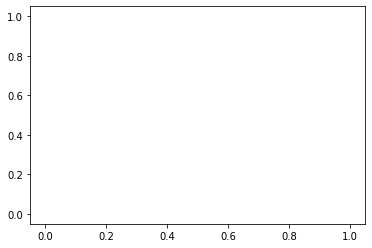

In [1]:
#Create a folder called celeba in home dir where reconstructed images will be stored
#Considered only 100000 images for training

import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as utils
import gc
import pywt
import IPython
import random
from random import sample
with __import__('importnb').Notebook():
        from wtvae_wt128 import CelebaDataset, VAE, Flatten

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
# os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
CUDA = True
BATCH_SIZE = 32
LOG_INTERVAL = 5
h_img = 128
w_img = 128
flat = h_img*w_img*3
train_losses = []

In [2]:
# w=pywt.Wavelet('bior2.2')


# dec_hi = torch.Tensor(w.dec_hi[::-1]).cuda() 
# dec_lo = torch.Tensor(w.dec_lo[::-1]).cuda()
# rec_hi = torch.Tensor(w.rec_hi).cuda()
# rec_lo = torch.Tensor(w.rec_lo).cuda()

# inv_filters = torch.stack([rec_lo.unsqueeze(0)*rec_lo.unsqueeze(1),
#                            rec_lo.unsqueeze(0)*rec_hi.unsqueeze(1),
#                            rec_hi.unsqueeze(0)*rec_lo.unsqueeze(1),
#                            rec_hi.unsqueeze(0)*rec_hi.unsqueeze(1)], dim=0)

# def iwt(vres, levels=1):
#     h = vres.size(2)
#     w = vres.size(3)
#     res = vres.contiguous().view(-1,h//2,2,w//2).transpose(1,2).contiguous().view(-1,4,h//2,w//2).clone()
#     print(res.shape)
#     if levels>1:
#         res[:,:1] = iwt(res[:,:1], levels=levels-1)
#     res = torch.nn.functional.conv_transpose2d(res, Variable(inv_filters[:,None]),stride=2)
#     res = res[:,:,2:-2,2:-2] #removing padding
# #     print(res.shape)
#     return res

def truncated_normal_(tensor, mean=0, std=0.02):
    size = tensor.shape
    tmp = tensor.new_empty(size + (4,)).normal_()
    valid = (tmp < 2) & (tmp > -2)
    ind = valid.max(-1, keepdim=True)[1]
    tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
    tensor.data.mul_(std).add_(mean)
    
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        with torch.no_grad():
            truncated_normal_(m.weight.data, mean=0, std=0.02)
        nn.init.constant_(m.bias.data, 0.0)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, mean=0, std=0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [3]:
class LearnIWT(nn.Module):
    def __init__(self, image_channels=3, z_dim=100, device=None):
        super(LearnIWT, self).__init__()
        
        if device is None:
            self.cuda = False
            self.device = None
        else:
            self.device = device
            self.cuda = True
        
        self.z_dim = z_dim
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # X - Y Residual Encoder
        self.e1 = nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=True, padding_mode='zeros') #[b, 64, 64, 64]
        weights_init(self.e1)
        self.instance_norm_e1 = nn.InstanceNorm2d(num_features=64, affine=False)

        self.e2 = nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=True, padding_mode='zeros') #[b, 128, 32, 32]
        weights_init(self.e2)
        self.instance_norm_e2 = nn.InstanceNorm2d(num_features=128, affine=False)

        self.e3 = nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=True, padding_mode='zeros') #[b, 256, 16, 16]
        weights_init(self.e3)
        self.instance_norm_e3 = nn.InstanceNorm2d(num_features=256, affine=False)

        self.e4 = nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=True, padding_mode='zeros') #[b, 512, 8, 8]
        weights_init(self.e4)
        self.instance_norm_e4 = nn.InstanceNorm2d(num_features=512, affine=False)
        
#         self.e5 = nn.Conv2d(512, 512, 4, stride=2, padding=1, bias=True, padding_mode='zeros') #[b, 512, 4, 4]
#         weights_init(self.e5)
#         self.instance_norm_e5 = nn.InstanceNorm2d(num_features=512, affine=False)
        
        self.fc_enc = nn.Linear(512 * 8 * 8, 256)
        weights_init(self.fc_enc)
        
        self.fc_mean = nn.Linear(256, z_dim)
        weights_init(self.fc_mean)
        
        self.fc_var = nn.Linear(256, z_dim)
        weights_init(self.fc_var)
        
        # IWT Decoder        
#         self.d1 = nn.Linear(3 * 128 * 128, 3 * 128 * 128)
        self.d1 = nn.Conv1d(3, 3, kernel_size=1, stride=1)
        weights_init(self.d1)
        self.mu1 = nn.Linear(z_dim, 3 * 128 * 128)
        self.var1 = nn.Linear(z_dim, 3 * 128 * 128)
        self.instance_norm_d1 = nn.InstanceNorm2d(num_features=3, affine=False)
        self.iwt1 = nn.ConvTranspose2d(image_channels, image_channels, kernel_size=5, stride=1, padding=2)
        
#         self.d2 = nn.Linear(3 * 128 * 128, 3 * 128 * 128)
#         weights_init(self.d2)
        self.mu2 = nn.Linear(z_dim, 3 * 128 * 128)
        self.var2 = nn.Linear(z_dim, 3 * 128 * 128)
        self.instance_norm_d2 = nn.InstanceNorm2d(num_features=3, affine=False)
        self.iwt2 = nn.ConvTranspose2d(image_channels, image_channels, kernel_size=5, stride=1, padding=2)
        
    
    def encode(self, x, y):
        h = self.leakyrelu(self.instance_norm_e1(self.e1(x-y)))   #[b, 64, 64, 64]
        h = self.leakyrelu(self.instance_norm_e2(self.e2(h)))     #[b, 128, 32, 32]
        h = self.leakyrelu(self.instance_norm_e3(self.e3(h)))     #[b, 256, 16, 16]
        h = self.leakyrelu(self.instance_norm_e4(self.e4(h)))     #[b, 512, 8, 8]
#         h = self.leakyrelu(self.instance_norm_e5(self.e5(h)))     #[b, 512, 4, 4]
        h = self.leakyrelu(self.fc_enc(h.view(-1,512*8*8)))       #[b, 512 * 4 * 4]
        
        return self.fc_mean(h), F.softplus(self.fc_var(h))        #[b, z_dim]

    def reparameterize(self, mu, var):
        std = torch.sqrt(var)
        if self.cuda:
            eps = torch.FloatTensor(std.size()).normal_().to(self.device)
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu) 
    
    def decode(self, y, z):
        mu = self.mu1(z).reshape(-1, 3, 128, 128)
        var = self.var1(z).reshape(-1, 3, 128, 128)
        h = self.leakyrelu(var*self.instance_norm_d1(self.d1(y.view(y.shape[0], 3, -1)).reshape(-1, 3, 128, 128)) + mu) #[b, 3, 128, 128]
        h = self.leakyrelu(self.iwt1(h))                               #[b, 3, 128, 128]
        
        mu = self.mu2(z).reshape(-1, 3, 128, 128)
        var = self.var2(z).reshape(-1, 3, 128, 128)
        h = self.leakyrelu(var*self.instance_norm_d2(self.d1(h.view(h.shape[0], 3, -1)).reshape(-1, 3, 128, 128)) + mu) #[b, 3, 128, 128]
        h = self.leakyrelu(self.iwt2(h))                               #[b, 3, 128, 128]
        
        return self.sigmoid(h)
        
        
    def forward(self, x, y):
        mu, var = self.encode(x, y)
        if self.training:
            z = self.reparameterize(mu, var)
        else:
            z = mu
        x_hat = self.decode(y, z)
        
        return x_hat, mu, var
        
        
    def loss_function(self, x, x_hat, mu, var) -> Variable:
        
        # Loss btw reconstructed img and original img
        BCE = F.mse_loss(x_hat.view(-1), x.view(-1))
        
        logvar = torch.log(var)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * 0.01
#         KLD /= x.shape[0] * 3 * 64 * 64

        return BCE + KLD
        
        
        

In [4]:
# test = torch.zeros((32,3,32,32))
# test1 = test.contiguous().view(-1,32//2,2,32//2).transpose(1,2).contiguous().view(-1,4,32//2,32//2).clone()
# print(test1.shape)
# #torch.nn.functional.conv_transpose2d(test1.cuda(), Variable(inv_filters[:,None]),stride=2)
# t = nn.ConvTranspose2d(3, 3, kernel_size=6, stride=2)
# t1 = Variable(inv_filters[:,None])
# print(t1.shape)
# print(t.weight.shape)

# with torch.no_grad():
#     t.weight = torch.nn.Parameter(t1)

In [5]:
# Create celeba dataset
random.seed(2020)
root_dir = '/nobackup/users/swhan/'
img_dir = os.path.join(root_dir, 'celeba128/')
image_files = os.listdir(img_dir)
image_files = random.sample(image_files, 10000)
train_dataset = CelebaDataset(img_dir, image_files, WT=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=10, shuffle=True)
sample_dataset = Subset(train_dataset, sample(range(len(train_dataset)), 8))
sample_loader = DataLoader(sample_dataset, batch_size=8, shuffle=False)

In [6]:
# Zeroing out all other patches than the first for WT image: 4D: B * C * H * W
def zero_patches(img, patch_sz):
    zeros = torch.zeros((img.shape[0], img.shape[1], img.shape[2], img.shape[3]))
    zeros[:,:,:patch_sz,:patch_sz] = img[:,:,:patch_sz,:patch_sz]
    
    return zeros

In [7]:
def train(epoch, model, optimizer, train_loader):
    # toggle model to train mode
    model.train()
    train_loss = 0
    
    for batch_idx, data in enumerate(train_loader):
        
        if CUDA:
            data0 = data.to('cuda:0')
            data1 = data.clone().to('cuda:1')

        optimizer.zero_grad()
        
        # Get Y
        Y = wt_model(data1)[0]
        # Zeroing out all other patches
        Y = zero_patches(Y, 32)
        x_hat, mu, var = iwt_model(data0, Y.to('cuda:0'))
        # Fix loss function
        loss = iwt_model.loss_function(x_hat, data0, mu, var)
#         torch.cuda.empty_cache()
#         del data0, data1
        loss.backward()
        
        train_losses.append(loss.item())
        train_loss += loss
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data),
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss / len(data)))
            
            n = min(data.size(0), 8)  

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [ ]:
# Loading WT model and setting to eval for inference
wt_model = VAE()
wt_model.load_state_dict(torch.load(os.path.join(root_dir, 'wtvae_epoch82.pth')))
wt_model.to('cuda:1')
wt_model.eval()
iwt_model = LearnIWT(device='cuda:0').to('cuda:0')

postfix = '128_rest0_reuse'
sample_dir = os.path.join(root_dir, 'image_samples/')
model_dir = os.path.join(root_dir, 'models/')
if os.path.isdir('/nobackup/users/swhan/image_samples/celeba_iwtvae_{}'.format(postfix)) or os.path.isdir('/nobackup/users/swhan/models/iwtvae64_models_{}'.format(postfix)):
    raise Exception('Image sample / model directory exists!')
else:
    os.mkdir('/nobackup/users/swhan/image_samples/celeba_iwtvae_{}'.format(postfix))
    os.mkdir('/nobackup/users/swhan/models/iwtvae_models_{}'.format(postfix))
             
train_losses = []
gc.collect()
EPOCHS = 100

optimizer = optim.Adam(iwt_model.parameters(), lr=1e-3)

for epoch in range(1, EPOCHS + 1):
    train(epoch, iwt_model, optimizer, train_loader)

    with torch.no_grad():
        iwt_model.eval()

        for data in sample_loader:
            if CUDA:
                data0 = data.to('cuda:0')
                data1 = data.to('cuda:1')
            
            z_sample = torch.randn(data.shape[0],100).to('cuda:0')
            
            Y = wt_model(data1)[0].to('cuda:0')
            mu, var = iwt_model.encode(data0, Y)
            x_hat = iwt_model.decode(Y, mu)
            x_sample = iwt_model.decode(Y, z_sample)
            
            save_image(x_hat.cpu(), sample_dir + '/celeba_iwtvae_{}/sample_recon'.format(postfix) + str(epoch) + '.png') 
            save_image(x_sample.cpu(), sample_dir + '/celeba_iwtvae_{}/sample_z'.format(postfix) + str(epoch) + '.png')
            save_image(Y.cpu(), sample_dir + '/celeba_iwtvae_{}/sample_y'.format(postfix) + str(epoch) + '.png') 
            save_image(data.cpu(), sample_dir + '/celeba_iwtvae_{}/sample'.format(postfix) + str(epoch) + '.png')  
    
    torch.save(iwt_model.state_dict(), model_dir + '/iwtvae_models_{}/iwtvae_epoch{}.pth'.format(postfix, epoch))

Train Epoch: 1 [0/10000 (0%)]	Loss: 0.279039
Train Epoch: 1 [160/10000 (2%)]	Loss: 0.147880
Train Epoch: 1 [320/10000 (3%)]	Loss: 0.045918
Train Epoch: 1 [480/10000 (5%)]	Loss: 0.028264
Train Epoch: 1 [640/10000 (6%)]	Loss: 0.016283
Train Epoch: 1 [800/10000 (8%)]	Loss: 0.012666
Train Epoch: 1 [960/10000 (10%)]	Loss: 0.007547
Train Epoch: 1 [1120/10000 (11%)]	Loss: 0.006196
Train Epoch: 1 [1280/10000 (13%)]	Loss: 0.004594
Train Epoch: 1 [1440/10000 (14%)]	Loss: 0.003773
Train Epoch: 1 [1600/10000 (16%)]	Loss: 0.003608
Train Epoch: 1 [1760/10000 (18%)]	Loss: 0.003043
Train Epoch: 1 [1920/10000 (19%)]	Loss: 0.003133
Train Epoch: 1 [2080/10000 (21%)]	Loss: 0.002835
Train Epoch: 1 [2240/10000 (22%)]	Loss: 0.002912
Train Epoch: 1 [2400/10000 (24%)]	Loss: 0.002784
Train Epoch: 1 [2560/10000 (26%)]	Loss: 0.002694
Train Epoch: 1 [2720/10000 (27%)]	Loss: 0.002669
Train Epoch: 1 [2880/10000 (29%)]	Loss: 0.002653
Train Epoch: 1 [3040/10000 (30%)]	Loss: 0.002910
Train Epoch: 1 [3200/10000 (32%)]	L

Train Epoch: 3 [6560/10000 (65%)]	Loss: 0.001908
Train Epoch: 3 [6720/10000 (67%)]	Loss: 0.001857
Train Epoch: 3 [6880/10000 (69%)]	Loss: 0.002275
Train Epoch: 3 [7040/10000 (70%)]	Loss: 0.002341
Train Epoch: 3 [7200/10000 (72%)]	Loss: 0.001924
Train Epoch: 3 [7360/10000 (73%)]	Loss: 0.002207
Train Epoch: 3 [7520/10000 (75%)]	Loss: 0.002245
Train Epoch: 3 [7680/10000 (77%)]	Loss: 0.002239
Train Epoch: 3 [7840/10000 (78%)]	Loss: 0.002147
Train Epoch: 3 [8000/10000 (80%)]	Loss: 0.002416
Train Epoch: 3 [8160/10000 (81%)]	Loss: 0.002138
Train Epoch: 3 [8320/10000 (83%)]	Loss: 0.001996
Train Epoch: 3 [8480/10000 (85%)]	Loss: 0.002385
Train Epoch: 3 [8640/10000 (86%)]	Loss: 0.002267
Train Epoch: 3 [8800/10000 (88%)]	Loss: 0.001885
Train Epoch: 3 [8960/10000 (89%)]	Loss: 0.002113
Train Epoch: 3 [9120/10000 (91%)]	Loss: 0.002392
Train Epoch: 3 [9280/10000 (93%)]	Loss: 0.002314
Train Epoch: 3 [9440/10000 (94%)]	Loss: 0.001949
Train Epoch: 3 [9600/10000 (96%)]	Loss: 0.001792
Train Epoch: 3 [9760

Train Epoch: 6 [2880/10000 (29%)]	Loss: 0.002050
Train Epoch: 6 [3040/10000 (30%)]	Loss: 0.001897
Train Epoch: 6 [3200/10000 (32%)]	Loss: 0.002268
Train Epoch: 6 [3360/10000 (34%)]	Loss: 0.002053
Train Epoch: 6 [3520/10000 (35%)]	Loss: 0.002127
Train Epoch: 6 [3680/10000 (37%)]	Loss: 0.002173
Train Epoch: 6 [3840/10000 (38%)]	Loss: 0.001786
Train Epoch: 6 [4000/10000 (40%)]	Loss: 0.001991
Train Epoch: 6 [4160/10000 (42%)]	Loss: 0.002052
Train Epoch: 6 [4320/10000 (43%)]	Loss: 0.001938
Train Epoch: 6 [4480/10000 (45%)]	Loss: 0.001967
Train Epoch: 6 [4640/10000 (46%)]	Loss: 0.002060
Train Epoch: 6 [4800/10000 (48%)]	Loss: 0.002052
Train Epoch: 6 [4960/10000 (50%)]	Loss: 0.001974
Train Epoch: 6 [5120/10000 (51%)]	Loss: 0.002168
Train Epoch: 6 [5280/10000 (53%)]	Loss: 0.001964
Train Epoch: 6 [5440/10000 (54%)]	Loss: 0.001957
Train Epoch: 6 [5600/10000 (56%)]	Loss: 0.002110
Train Epoch: 6 [5760/10000 (58%)]	Loss: 0.002215
Train Epoch: 6 [5920/10000 (59%)]	Loss: 0.001939
Train Epoch: 6 [6080

Train Epoch: 8 [9440/10000 (94%)]	Loss: 0.001653
Train Epoch: 8 [9600/10000 (96%)]	Loss: 0.002053
Train Epoch: 8 [9760/10000 (97%)]	Loss: 0.001862
Train Epoch: 8 [9920/10000 (99%)]	Loss: 0.001873
====> Epoch: 8 Average loss: 0.0020
Train Epoch: 9 [0/10000 (0%)]	Loss: 0.001845
Train Epoch: 9 [160/10000 (2%)]	Loss: 0.002308
Train Epoch: 9 [320/10000 (3%)]	Loss: 0.002021
Train Epoch: 9 [480/10000 (5%)]	Loss: 0.002021
Train Epoch: 9 [640/10000 (6%)]	Loss: 0.002163
Train Epoch: 9 [800/10000 (8%)]	Loss: 0.001798
Train Epoch: 9 [960/10000 (10%)]	Loss: 0.001794
Train Epoch: 9 [1120/10000 (11%)]	Loss: 0.001766
Train Epoch: 9 [1280/10000 (13%)]	Loss: 0.002066
Train Epoch: 9 [1440/10000 (14%)]	Loss: 0.001797
Train Epoch: 9 [1600/10000 (16%)]	Loss: 0.002054
Train Epoch: 9 [1760/10000 (18%)]	Loss: 0.001966
Train Epoch: 9 [1920/10000 (19%)]	Loss: 0.001811
Train Epoch: 9 [2080/10000 (21%)]	Loss: 0.001920
Train Epoch: 9 [2240/10000 (22%)]	Loss: 0.001849
Train Epoch: 9 [2400/10000 (24%)]	Loss: 0.001960

Train Epoch: 11 [5440/10000 (54%)]	Loss: 0.008596
Train Epoch: 11 [5600/10000 (56%)]	Loss: 0.009604
Train Epoch: 11 [5760/10000 (58%)]	Loss: 0.011997
Train Epoch: 11 [5920/10000 (59%)]	Loss: 0.008590
Train Epoch: 11 [6080/10000 (61%)]	Loss: 0.010587
Train Epoch: 11 [6240/10000 (62%)]	Loss: 0.009241
Train Epoch: 11 [6400/10000 (64%)]	Loss: 0.008226
Train Epoch: 11 [6560/10000 (65%)]	Loss: 0.011377
Train Epoch: 11 [6720/10000 (67%)]	Loss: 0.010398
Train Epoch: 11 [6880/10000 (69%)]	Loss: 0.009964
Train Epoch: 11 [7040/10000 (70%)]	Loss: 0.009992
Train Epoch: 11 [7200/10000 (72%)]	Loss: 0.008497
Train Epoch: 11 [7360/10000 (73%)]	Loss: 0.008295
Train Epoch: 11 [7520/10000 (75%)]	Loss: 0.008781
Train Epoch: 11 [7680/10000 (77%)]	Loss: 0.007290
Train Epoch: 11 [7840/10000 (78%)]	Loss: 0.006516
Train Epoch: 11 [8000/10000 (80%)]	Loss: 0.007024
Train Epoch: 11 [8160/10000 (81%)]	Loss: 0.006506
Train Epoch: 11 [8320/10000 (83%)]	Loss: 0.007108
Train Epoch: 11 [8480/10000 (85%)]	Loss: 0.006465


Train Epoch: 14 [1280/10000 (13%)]	Loss: 0.003056
Train Epoch: 14 [1440/10000 (14%)]	Loss: 0.003016
Train Epoch: 14 [1600/10000 (16%)]	Loss: 0.003011
Train Epoch: 14 [1760/10000 (18%)]	Loss: 0.002887
Train Epoch: 14 [1920/10000 (19%)]	Loss: 0.002769
Train Epoch: 14 [2080/10000 (21%)]	Loss: 0.003035
Train Epoch: 14 [2240/10000 (22%)]	Loss: 0.002992
Train Epoch: 14 [2400/10000 (24%)]	Loss: 0.002549
Train Epoch: 14 [2560/10000 (26%)]	Loss: 0.003029
Train Epoch: 14 [2720/10000 (27%)]	Loss: 0.002624
Train Epoch: 14 [2880/10000 (29%)]	Loss: 0.002547
Train Epoch: 14 [3040/10000 (30%)]	Loss: 0.003040
Train Epoch: 14 [3200/10000 (32%)]	Loss: 0.002872
Train Epoch: 14 [3360/10000 (34%)]	Loss: 0.003574
Train Epoch: 14 [3520/10000 (35%)]	Loss: 0.002691
Train Epoch: 14 [3680/10000 (37%)]	Loss: 0.002701
Train Epoch: 14 [3840/10000 (38%)]	Loss: 0.003245
Train Epoch: 14 [4000/10000 (40%)]	Loss: 0.003329
Train Epoch: 14 [4160/10000 (42%)]	Loss: 0.002995
Train Epoch: 14 [4320/10000 (43%)]	Loss: 0.002489


Train Epoch: 16 [7200/10000 (72%)]	Loss: 0.004520
Train Epoch: 16 [7360/10000 (73%)]	Loss: 0.005110
Train Epoch: 16 [7520/10000 (75%)]	Loss: 0.004148
Train Epoch: 16 [7680/10000 (77%)]	Loss: 0.004741
Train Epoch: 16 [7840/10000 (78%)]	Loss: 0.005211
Train Epoch: 16 [8000/10000 (80%)]	Loss: 0.007273
Train Epoch: 16 [8160/10000 (81%)]	Loss: 0.011803
Train Epoch: 16 [8320/10000 (83%)]	Loss: 0.004207
Train Epoch: 16 [8480/10000 (85%)]	Loss: 0.005787
Train Epoch: 16 [8640/10000 (86%)]	Loss: 0.035575
Train Epoch: 16 [8800/10000 (88%)]	Loss: 0.018202
Train Epoch: 16 [8960/10000 (89%)]	Loss: 0.013398
Train Epoch: 16 [9120/10000 (91%)]	Loss: 0.007827
Train Epoch: 16 [9280/10000 (93%)]	Loss: 0.010015
Train Epoch: 16 [9440/10000 (94%)]	Loss: 0.008275
Train Epoch: 16 [9600/10000 (96%)]	Loss: 0.003722
Train Epoch: 16 [9760/10000 (97%)]	Loss: 0.003596
Train Epoch: 16 [9920/10000 (99%)]	Loss: 0.009564
====> Epoch: 16 Average loss: 0.0054
Train Epoch: 17 [0/10000 (0%)]	Loss: 0.014846
Train Epoch: 17 [

Train Epoch: 19 [3040/10000 (30%)]	Loss: 0.006062
Train Epoch: 19 [3200/10000 (32%)]	Loss: 0.005822
Train Epoch: 19 [3360/10000 (34%)]	Loss: 0.010751
Train Epoch: 19 [3520/10000 (35%)]	Loss: 0.004392
Train Epoch: 19 [3680/10000 (37%)]	Loss: 0.004631
Train Epoch: 19 [3840/10000 (38%)]	Loss: 0.003857
Train Epoch: 19 [4000/10000 (40%)]	Loss: 0.003272
Train Epoch: 19 [4160/10000 (42%)]	Loss: 0.003077
Train Epoch: 19 [4320/10000 (43%)]	Loss: 0.003084
Train Epoch: 19 [4480/10000 (45%)]	Loss: 0.002180
Train Epoch: 19 [4640/10000 (46%)]	Loss: 0.002916
Train Epoch: 19 [4800/10000 (48%)]	Loss: 0.002681
Train Epoch: 19 [4960/10000 (50%)]	Loss: 0.002537
Train Epoch: 19 [5120/10000 (51%)]	Loss: 0.002244
Train Epoch: 19 [5280/10000 (53%)]	Loss: 0.002290
Train Epoch: 19 [5440/10000 (54%)]	Loss: 0.002280
Train Epoch: 19 [5600/10000 (56%)]	Loss: 0.002402
Train Epoch: 19 [5760/10000 (58%)]	Loss: 0.002629
Train Epoch: 19 [5920/10000 (59%)]	Loss: 0.002755
Train Epoch: 19 [6080/10000 (61%)]	Loss: 0.002264


Train Epoch: 21 [8960/10000 (89%)]	Loss: 0.002951
Train Epoch: 21 [9120/10000 (91%)]	Loss: 0.002210
Train Epoch: 21 [9280/10000 (93%)]	Loss: 0.002925
Train Epoch: 21 [9440/10000 (94%)]	Loss: 0.002965
Train Epoch: 21 [9600/10000 (96%)]	Loss: 0.003948
Train Epoch: 21 [9760/10000 (97%)]	Loss: 0.006008
Train Epoch: 21 [9920/10000 (99%)]	Loss: 0.010489
====> Epoch: 21 Average loss: 0.0040
Train Epoch: 22 [0/10000 (0%)]	Loss: 0.011451
Train Epoch: 22 [160/10000 (2%)]	Loss: 0.024663
Train Epoch: 22 [320/10000 (3%)]	Loss: 0.021134
Train Epoch: 22 [480/10000 (5%)]	Loss: 0.026109
Train Epoch: 22 [640/10000 (6%)]	Loss: 0.010062
Train Epoch: 22 [800/10000 (8%)]	Loss: 0.009284
Train Epoch: 22 [960/10000 (10%)]	Loss: 0.006199
Train Epoch: 22 [1120/10000 (11%)]	Loss: 0.006657
Train Epoch: 22 [1280/10000 (13%)]	Loss: 0.019667
Train Epoch: 22 [1440/10000 (14%)]	Loss: 0.010270
Train Epoch: 22 [1600/10000 (16%)]	Loss: 0.006982
Train Epoch: 22 [1760/10000 (18%)]	Loss: 0.003781
Train Epoch: 22 [1920/10000 

Train Epoch: 24 [4800/10000 (48%)]	Loss: 0.004938
Train Epoch: 24 [4960/10000 (50%)]	Loss: 0.003564
Train Epoch: 24 [5120/10000 (51%)]	Loss: 0.003690
Train Epoch: 24 [5280/10000 (53%)]	Loss: 0.003263
Train Epoch: 24 [5440/10000 (54%)]	Loss: 0.003149
Train Epoch: 24 [5600/10000 (56%)]	Loss: 0.003205
Train Epoch: 24 [5760/10000 (58%)]	Loss: 0.002580
Train Epoch: 24 [5920/10000 (59%)]	Loss: 0.002793
Train Epoch: 24 [6080/10000 (61%)]	Loss: 0.003151
Train Epoch: 24 [6240/10000 (62%)]	Loss: 0.002738
Train Epoch: 24 [6400/10000 (64%)]	Loss: 0.003855
Train Epoch: 24 [6560/10000 (65%)]	Loss: 0.003802
Train Epoch: 24 [6720/10000 (67%)]	Loss: 0.003239
Train Epoch: 24 [6880/10000 (69%)]	Loss: 0.002541
Train Epoch: 24 [7040/10000 (70%)]	Loss: 0.002559
Train Epoch: 24 [7200/10000 (72%)]	Loss: 0.003325
Train Epoch: 24 [7360/10000 (73%)]	Loss: 0.002329
Train Epoch: 24 [7520/10000 (75%)]	Loss: 0.004091
Train Epoch: 24 [7680/10000 (77%)]	Loss: 0.003532
Train Epoch: 24 [7840/10000 (78%)]	Loss: 0.002378


In [ ]:
plt.plot(train_losses)
plt.show()

In [ ]:
sum(x.numel() for x in iwt_model.parameters())